# DID analysis about VADER scores of submissions

## Install and import packages

In [1]:
%pip install pandas vaderSentiment statsmodels matplotlib seaborn

import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Parameters

In [2]:
# パスの設定
treatment_path = './combined_texts_Palestine_Israel_IsraelPalestine_20241118_151608.csv'
control_path = './combined_texts_ps4homebrew_Exercise_voyageons_20241118_180836.csv'

# VADERの初期化
analyzer = SentimentIntensityAnalyzer()

## Load data

In [3]:
# Load CSV files
treatment_df = pd.read_csv(treatment_path)
control_df = pd.read_csv(control_path)

# Display basic information about the datasets to understand their structure
treatment_df.info(), control_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261421 entries, 0 to 261420
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         260299 non-null  object
 1   created_utc  261419 non-null  object
dtypes: object(2)
memory usage: 4.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15236 entries, 0 to 15235
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         15084 non-null  object
 1   created_utc  15236 non-null  object
dtypes: object(2)
memory usage: 238.2+ KB


(None, None)

## Calculates VADER scores

In [4]:
# Function to calculate VADER score
def calculate_vader_score(text):
    text = str(text)
    return analyzer.polarity_scores(text)['compound']

# Calculate VADER scores for each text entry
treatment_df['vader_score'] = treatment_df['text'].apply(calculate_vader_score)
control_df['vader_score'] = control_df['text'].apply(calculate_vader_score)

## Grouping data into treatment or control

In [5]:
# Convert 'created_utc' to datetime and create treatment/control dummy variables
treatment_df['created_utc'] = pd.to_datetime(treatment_df['created_utc'], utc=True)
control_df['created_utc'] = pd.to_datetime(control_df['created_utc'], utc=True)

# Calculate average VADER scores for each day
treatment_daily_avg = treatment_df.groupby('created_utc')['vader_score'].mean().reset_index()
control_daily_avg = control_df.groupby('created_utc')['vader_score'].mean().reset_index()

# Add a treatment indicator
treatment_daily_avg['treatment'] = 1
control_daily_avg['treatment'] = 0

# Combine treatment and control data
combined_df = pd.concat([treatment_daily_avg, control_daily_avg])

# Create a binary variable for pre- and post- October 1, 2024
cutoff_date = pd.to_datetime('2024-10-01', utc=True)
combined_df['post_treatment'] = (combined_df['created_utc'] >= cutoff_date).astype(int)

# Group by day to count number of submissions per day for each group
combined_df['date'] = combined_df['created_utc'].dt.date
daily_avg_scores = combined_df.groupby(['date', 'treatment', 'post_treatment', 'vader_score']).size().reset_index(name='submission_count')

# Display the resulting daily submission counts
daily_avg_scores.head()

,date,treatment,post_treatment,vader_score,submission_count
0,2024-07-28,0,0,-0.4404,1
1,2024-07-28,0,0,-0.1280,1
2,2024-07-28,0,0,0.0000,6
3,2024-07-28,0,0,0.2023,1
4,2024-07-28,0,0,0.3089,1


## Create model and output summary

In [6]:
import statsmodels.formula.api as smf

# Fit the DID model
daily_avg_scores['interaction'] = daily_avg_scores['treatment'] * daily_avg_scores['post_treatment']
model_weighted = smf.wls('vader_score ~ treatment + post_treatment + interaction', data=daily_avg_scores, weights=daily_avg_scores['submission_count']).fit()
print(model_weighted.summary())

                            WLS Regression Results                            
Dep. Variable:            vader_score   R-squared:                       0.019
Model:                            WLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     825.0
Date:                Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                        18:14:59   Log-Likelihood:            -1.3679e+05
No. Observations:              127090   AIC:                         2.736e+05
Df Residuals:                  127086   BIC:                         2.736e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1940      0.008     23.

## Visualization

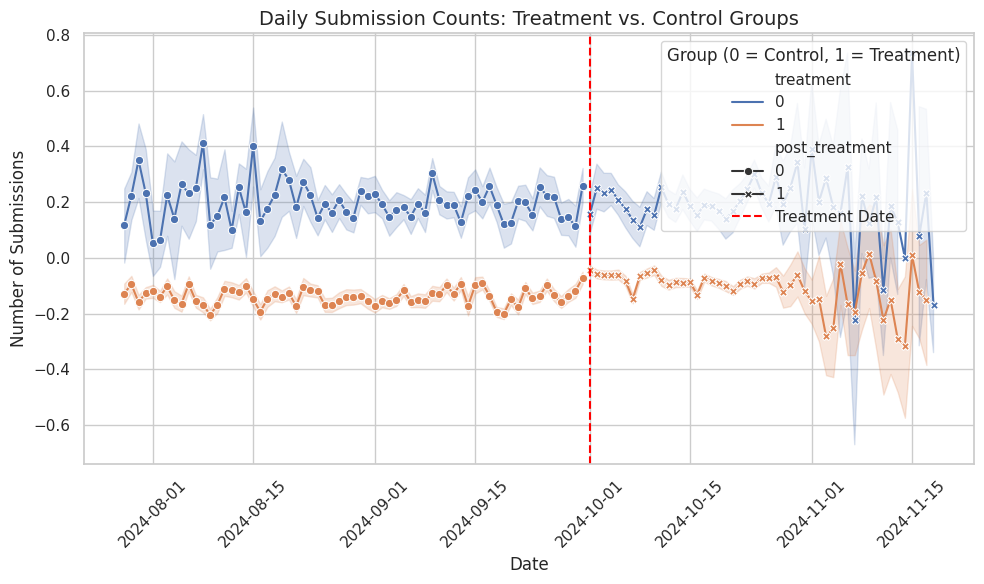

In [7]:
# Set plot style
sns.set(style="whitegrid")

# Plot daily submission counts for treatment and control groups, before and after the treatment date
plt.figure(figsize=(10, 6))

# Plot submission counts over time for treatment and control groups
sns.lineplot(data=combined_df, x='date', y='vader_score', hue='treatment', style='post_treatment', markers=True, dashes=False)

# Add vertical line indicating the treatment date
plt.axvline(pd.to_datetime('2024-10-01'), color='red', linestyle='--', label='Treatment Date')

# Labels and title
plt.title('Daily Submission Counts: Treatment vs. Control Groups', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Submissions', fontsize=12)
plt.legend(title='Group (0 = Control, 1 = Treatment)')
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()
